# Beta Experiments Analysis

This notebook analyzes the results from beta experiments:
- 4 beta values: [0.8, 1.2, 1.8, 2.4]
- 8 repetitions per beta
- Vocabulary size: 32

**Analysis:**
1. Loss curves with mean ± std for each beta
2. Comparison of final losses across betas
3. Check if models reach theoretical minimum (conditional entropy)

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import math

import RLM_files.datasets as datasets
import RLM_files.measures as measures

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## Configuration

In [7]:
# Experiment parameters
beta_values = [0.8, 1.2, 1.8, 2.4]
num_repetitions = 8
vocab_size = 32
num_layers = 1

# Results directory
results_dir = Path('results/beta_experiments')

print(f"Results directory: {results_dir}")
print(f"Beta values: {beta_values}")
print(f"Repetitions: {num_repetitions}")

Results directory: results/beta_experiments
Beta values: [0.8, 1.2, 1.8, 2.4]
Repetitions: 8


## Load Results

In [8]:
def load_experiment_results(beta, rep):
    """Load results for a specific beta and repetition."""
    filename = results_dir / f'rlm_v{vocab_size}_L{num_layers}_beta{beta}_rep{rep}.pt'
    
    if not filename.exists():
        print(f"Warning: File not found: {filename}")
        return None
    
    # Load with weights_only=False to handle argparse.Namespace
    data = torch.load(filename, weights_only=False)
    return data

# Load all results
all_results = {}

for beta in beta_values:
    all_results[beta] = []
    
    for rep in range(1, num_repetitions + 1):
        result = load_experiment_results(beta, rep)
        
        if result is not None:
            all_results[beta].append(result)
    
    print(f"Beta {beta}: Loaded {len(all_results[beta])} results")

print("\nAll results loaded!")

Beta 0.8: Loaded 8 results
Beta 1.2: Loaded 8 results
Beta 1.8: Loaded 8 results
Beta 2.4: Loaded 8 results

All results loaded!


## Extract Theoretical Minimum (Already Computed)

In [9]:
# Extract pre-computed entropy and marginal from results
theoretical_minimums = {}
marginal_entropies = {}

for beta in beta_values:
    theoretical_minimums[beta] = []
    marginal_entropies[beta] = []
    
    for result in all_results[beta]:
        if result is not None and 'output' in result:
            # Extract pre-computed conditional entropy
            entropy = result['output']['entropy']
            marginal = result['output']['marginal']
            theoretical_minimums[beta].append(entropy)
            marginal_entropies[beta].append(marginal)
    
    mean_entropy = np.mean(theoretical_minimums[beta])
    std_entropy = np.std(theoretical_minimums[beta])
    mean_marginal = np.mean(marginal_entropies[beta])
    print(f"Beta {beta}: Conditional entropy = {mean_entropy:.4f} ± {std_entropy:.4f}, Marginal = {mean_marginal:.4f}")

print("\nTheoretical minimums extracted!")

Beta 0.8: Conditional entropy = 3.3792 ± 0.0052, Marginal = 3.4624
Beta 1.2: Conditional entropy = 3.0927 ± 0.0320, Marginal = 3.4436
Beta 1.8: Conditional entropy = 2.4028 ± 0.0676, Marginal = 3.3702
Beta 2.4: Conditional entropy = 1.9332 ± 0.0682, Marginal = 3.3107

Theoretical minimums extracted!


## Extract Training Dynamics

In [10]:
def extract_dynamics(result_data):
    """Extract training dynamics from result data."""
    if 'output' in result_data:
        dynamics = result_data['output']['dynamics']
    else:
        # If saved with checkpoints, need to reconstruct
        return None
    
    steps = [d['t'] for d in dynamics]
    test_losses = [d['testloss'] for d in dynamics]
    test_accs = [d['testacc'] for d in dynamics]
    
    return {
        'steps': np.array(steps),
        'test_loss': np.array(test_losses),
        'test_acc': np.array(test_accs)
    }

# Extract dynamics for all experiments
all_dynamics = {}

for beta in beta_values:
    all_dynamics[beta] = []
    
    for result in all_results[beta]:
        dynamics = extract_dynamics(result)
        if dynamics is not None:
            all_dynamics[beta].append(dynamics)
    
    print(f"Beta {beta}: Extracted {len(all_dynamics[beta])} dynamics")

print("\nDynamics extracted!")

Beta 0.8: Extracted 8 dynamics
Beta 1.2: Extracted 8 dynamics
Beta 1.8: Extracted 8 dynamics
Beta 2.4: Extracted 8 dynamics

Dynamics extracted!


## Plot 1: Loss Curves with Mean ± Std for Each Beta

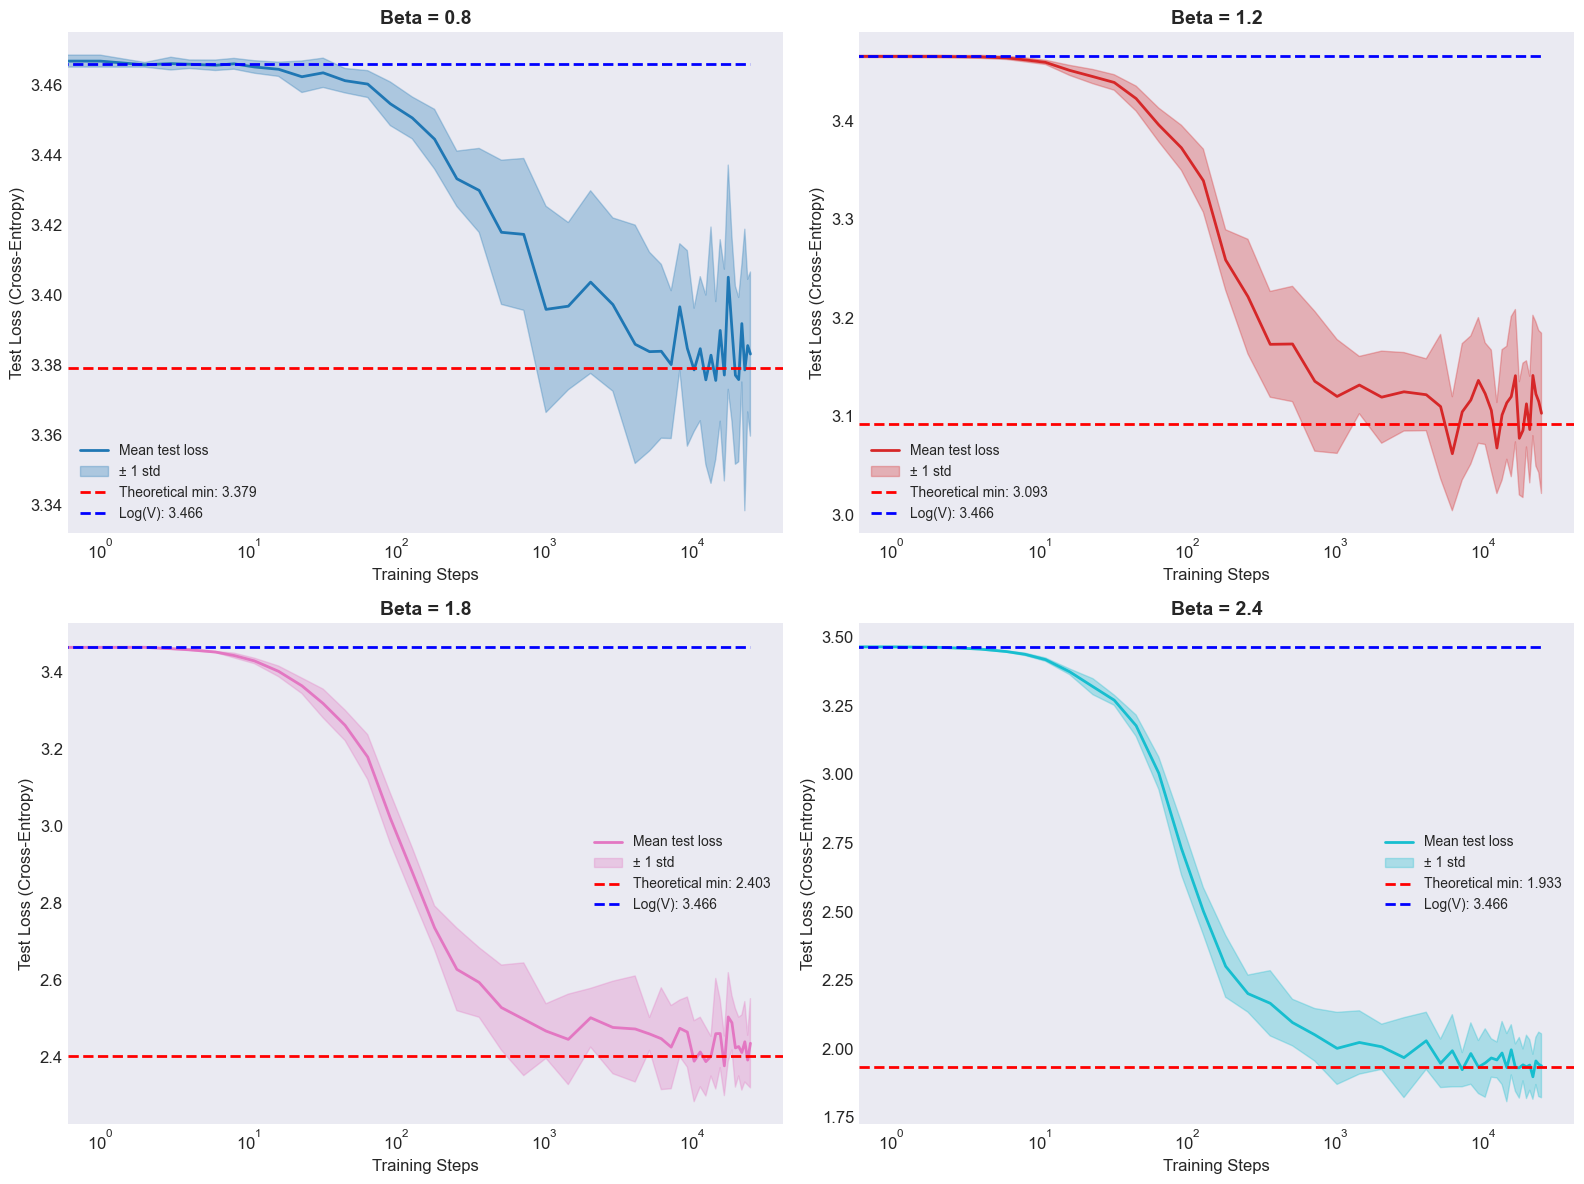

In [27]:
max_loss = np.log(32)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

colors = plt.cm.tab10(np.linspace(0, 1, len(beta_values)))

for idx, beta in enumerate(beta_values):
    ax = axes[idx]
    
    if len(all_dynamics[beta]) == 0:
        ax.text(0.5, 0.5, f'No data for beta={beta}', 
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    # Get common steps (use the first run as reference)
    steps = all_dynamics[beta][0]['steps']
    
    # Collect all losses at each step
    all_losses = []
    for dynamics in all_dynamics[beta]:
        # Interpolate if steps don't match exactly
        if len(dynamics['steps']) == len(steps):
            all_losses.append(dynamics['test_loss'])
    
    all_losses = np.array(all_losses)
    
    # Compute mean and std
    mean_loss = np.mean(all_losses, axis=0)
    std_loss = np.std(all_losses, axis=0)
    
    # Plot mean with shaded std
    ax.plot(steps, mean_loss, linewidth=2, label='Mean test loss', color=colors[idx])
    ax.fill_between(steps, mean_loss - std_loss, mean_loss + std_loss, 
                     alpha=0.3, color=colors[idx], label='± 1 std')
    
    # Plot theoretical minimum
    mean_theoretical = np.mean(theoretical_minimums[beta])
    ax.axhline(y=mean_theoretical, color='red', linestyle='--', 
               linewidth=2, label=f'Theoretical min: {mean_theoretical:.3f}')

    ax.plot(steps, [max_loss]*len(steps), color='blue', linestyle='--', linewidth=2,
        label=f'Log(V): {max_loss:.3f}')

    ax.set_xlabel('Training Steps', fontsize=12)
    ax.set_ylabel('Test Loss (Cross-Entropy)', fontsize=12)
    ax.set_title(f'Beta = {beta}', fontsize=14, fontweight='bold')
    ax.grid(False)
    ax.legend(fontsize=10)
    ax.set_xscale('log')

plt.tight_layout()
plt.show()

## Plot 2: Compare Mean Loss Across All Betas

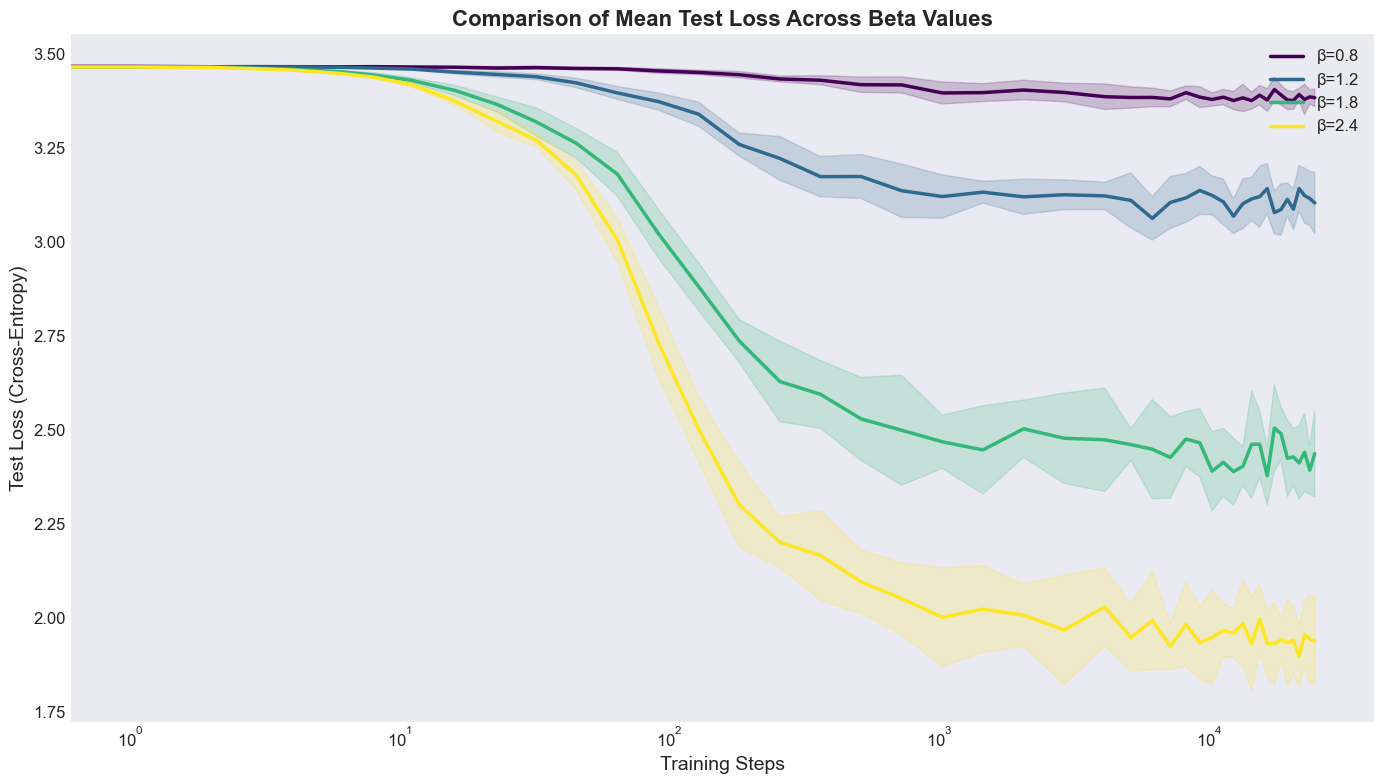

In [23]:
fig, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.viridis(np.linspace(0, 1, len(beta_values)))

for idx, beta in enumerate(beta_values):
    if len(all_dynamics[beta]) == 0:
        continue
    
    steps = all_dynamics[beta][0]['steps']
    
    # Collect all losses
    all_losses = []
    for dynamics in all_dynamics[beta]:
        if len(dynamics['steps']) == len(steps):
            all_losses.append(dynamics['test_loss'])
    
    all_losses = np.array(all_losses)
    mean_loss = np.mean(all_losses, axis=0)
    std_loss = np.std(all_losses, axis=0)
    
    # Plot mean
    ax.plot(steps, mean_loss, linewidth=2.5, label=f'β={beta}', color=colors[idx])
    ax.fill_between(steps, mean_loss - std_loss, mean_loss + std_loss, 
                     alpha=0.2, color=colors[idx])

ax.set_xlabel('Training Steps', fontsize=14)
ax.set_ylabel('Test Loss (Cross-Entropy)', fontsize=14)
ax.set_title('Comparison of Mean Test Loss Across Beta Values', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')
ax.grid(False)
ax.set_xscale('log')

plt.tight_layout()
plt.show()